# Imports

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import f1_score,recall_score, precision_score

import ast

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

%matplotlib inline

# Path and Load Data 

In [5]:
data = pd.read_csv('food_[actual_size=4881]_processed_merge.csv').food
data = pd.DataFrame(data=data)
data.head() 

,food
0,"['remind', 'deliveri', 'app', 'restaur', 'alwa..."
1,"['brais', 'chicken', 'leg', 'soy', 'sauc', 'vi..."
2,"['muffin', 'tin', 'great', 'meal', 'prep', 'in..."
3,"['test', 'everyth', 'spici', 'dill', 'pickl', ..."
4,"['eat', 'regular', 'big', 'mac', 'secret', 'lo..."


In [6]:
INTEREST_positive_tweets = data[:4968] 
print('INTEREST tweets size :', len(INTEREST_positive_tweets))
INTEREST_negative_tweets = data[4968:] 
print('non-INTEREST tweets size :', len(INTEREST_negative_tweets))

INTEREST tweets size : 4968
non-INTEREST tweets size : 4913


* Train test split: 20% will be in the test set, and 80% in the training set.


In [7]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = INTEREST_positive_tweets[4000:]
train_pos = INTEREST_positive_tweets[:4000]

test_neg = INTEREST_negative_tweets[4000:]
train_neg = INTEREST_negative_tweets[:4000]

In [8]:
train_x = pd.concat([train_pos, train_neg], axis=0) 
test_x = pd.concat([test_pos, test_neg], axis=0)

- Create the numpy array of positive labels and negative labels.

In [9]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [10]:
print('train shaoe:', train_y.shape)
print('test shape:', test_y.shape)

train shaoe: (8000, 1)
test shape: (1881, 1)


# Vocabulary for Politics Dataset 

In [11]:
def generate_tweets_list(dataframe_single):
    train_x_arr = [] 
    for index, row in dataframe_single.iterrows(): 
        for a in row.values: 
            train_x_arr.append(ast.literal_eval(a))
            
    return train_x_arr

In [12]:
train_x_arr = generate_tweets_list(train_x)

In [13]:
def build_freqs(train_x, train_y):
    
    yslist = np.squeeze(train_y).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, train_x):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [14]:
freqs = build_freqs(train_x_arr, train_y) 
train_x_arr = generate_tweets_list(train_x)

In [15]:
len(freqs)

14261

In [16]:
freqs_vis = np.ndarray((1,2))

for (word, label), value in freqs.items(): 
    if label == 1.0: 
        freqs_vis = np.append(freqs_vis, [[word, value]], axis=0)

        
freqs_vis

array([['0.0', '0.0'],
       ['remind', '10'],
       ['deliveri', '6'],
       ...,
       ['quot', '2'],
       ['wisdom', '1'],
       ['underdon', '1']], dtype='<U47')

In [17]:
freqs_vis = np.delete(freqs_vis, 0, axis=0)

In [18]:
freqs_vis = pd.DataFrame(data=freqs_vis, columns=['word', 'frequency'])
freqs_vis.head()

,word,frequency
0,remind,10
1,deliveri,6
2,app,5
3,restaur,288
4,alway,74


In [19]:
freqs_vis['frequency'] = freqs_vis['frequency'].astype('int')
freqs_vis = freqs_vis.nlargest(columns='frequency', n=20).iloc[2:,:]
freqs_vis

,word,frequency
5179,restaurantimposs,357
3,restaur,288
67,make,284
147,recip,257
116,food,255
2187,️,254
357,new,233
1880,thank,231
5184,🙏,230
108,get,224


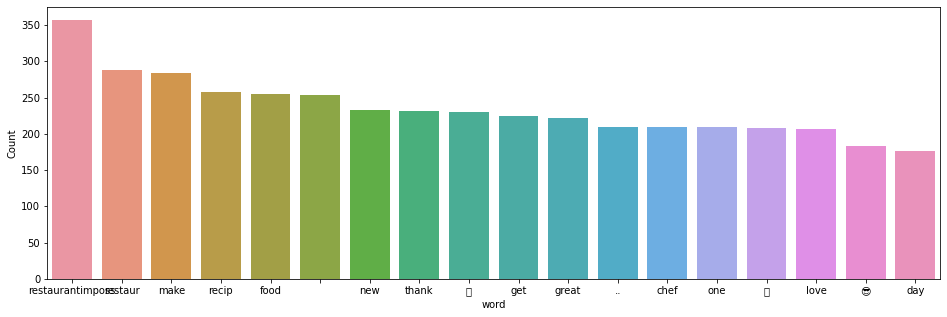

In [20]:
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=freqs_vis, x='word', y='frequency')
ax.set(ylabel = 'Count') 
plt.show() 

## Extract Features 
* Given a list of tweets, extract the features and store them in a matrix. Extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train the logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [21]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet 
        freqs: a dictionary corresponding to the frequencies of each tuple 
    Output:
        x: a feature vector of dimension (1, 3)
    '''
    x = np.zeros((1, 3)) 
    x[0,0] = 1 # bias term  
    
    for word in tweet: 
        
        x[0,1] += freqs.get((word, 1.0), 0) 
        
        x[0,2] += freqs.get((word, 0.0), 0) 
        
    assert(x.shape == (1, 3))
    return x 

In [22]:
# Ex 
train_x_arr[0]

['remind', 'deliveri', 'app', 'restaur', 'alway', 'seem']

In [23]:
extract_features(train_x_arr[0], freqs)

array([[  1., 401.,  83.]])

In [24]:
extract_features(['asd', 'asd', 'asd'], freqs)

array([[1., 0., 0.]])

In [25]:
X = np.zeros((len(train_x_arr), 3))
for i in range(len(train_x_arr)):
    X[i, :]= extract_features(train_x_arr[i], freqs) 
    
X[:5]

array([[  1., 401.,  83.],
       [  1., 766., 176.],
       [  1., 361.,  95.],
       [  1., 318.,  80.],
       [  1., 219., 276.]])

In [26]:
y = train_y

In [27]:
X_sparse = coo_matrix(X)
X, X_sparse, y = shuffle(X, X_sparse, y, random_state=0)

y

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [28]:
X

array([[1.000e+00, 2.792e+03, 1.815e+03],
       [1.000e+00, 1.670e+02, 1.130e+02],
       [1.000e+00, 1.810e+02, 6.470e+02],
       ...,
       [1.000e+00, 5.250e+02, 6.530e+02],
       [1.000e+00, 1.481e+03, 1.026e+03],
       [1.000e+00, 1.476e+03, 8.950e+02]])

In [29]:
vis_X = pd.DataFrame(data=X, columns=['bias', 'positive', 'negative'])
vis_y = pd.DataFrame(data=y, columns=['target']) 

vis_data = pd.concat([vis_X, vis_y], axis=1) 

vis_data.head() 

,bias,positive,negative,target
0,1.0,2792.0,1815.0,1.0
1,1.0,167.0,113.0,1.0
2,1.0,181.0,647.0,0.0
3,1.0,492.0,312.0,1.0
4,1.0,1824.0,782.0,1.0


<Figure size 720x720 with 0 Axes>

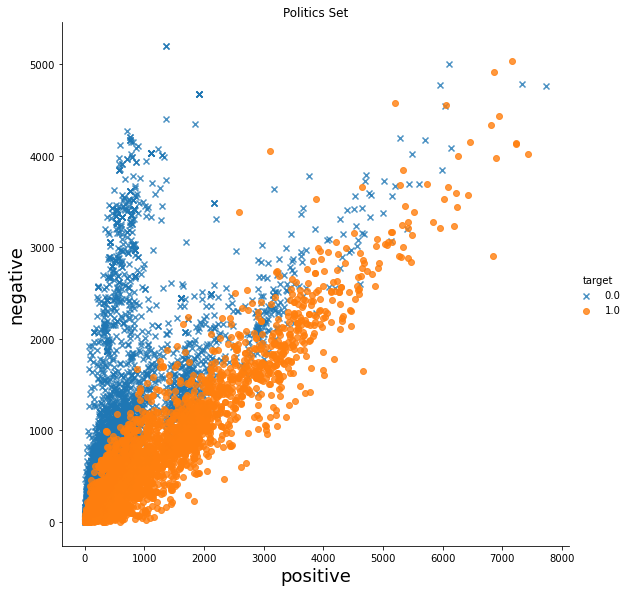

In [30]:
plt.figure(figsize=(10,10))
#plt.scatter(x='positive', y='negative', data=vis_data, c=vis_data.target, alpha=0.8, cmap='viridis', s=15)
sns.lmplot(x='positive', y='negative', data=vis_data, hue='target', fit_reg=False, height=8, markers=['x','o'])
plt.title('Politics Set')
plt.xlabel('positive', fontsize=18)
plt.ylabel('negative', fontsize=18) 
plt.show() 

# Classifier  1 : Logistic Regression 

* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 


# 1.1 Apply Logistic Regression and Cross - Validation 

* As a reminder, We have a balanced dataset. 

In [31]:
cross_val_score(LogisticRegression(), X, y.ravel())

array([0.851875, 0.836875, 0.84625 , 0.851875, 0.854375])

- We have very satisfying results. Let's do some hyper-parameter tuning.

# 1.2 Grid Search on Logistic Regression

In [32]:
%%time
gs_model = LogisticRegression(solver='liblinear') 
space = {
    'C': [1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

search = GridSearchCV(gs_model, space, scoring='accuracy', cv = 5) 
search.fit(X, y.ravel())  

Wall time: 399 ms


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100]},
             scoring='accuracy')

In [33]:
print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)

Best Score: 0.851875
Best Hyperparameters: {'C': 0.001}


In [34]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004989,0.001264,0.000796,3.979090e-04,0.0,{'C': 1e-10},0.848750,0.828125,0.847500,0.845625,0.851875,0.844375,0.008376,7
1,0.005984,0.001262,0.000598,4.885778e-04,0.00001,{'C': 1e-05},0.829375,0.821250,0.838750,0.837500,0.847500,0.834875,0.008913,9
2,0.008576,0.000488,0.000998,9.368364e-07,0.0001,{'C': 0.0001},0.836875,0.822500,0.847500,0.845625,0.855625,0.841625,0.011268,8
3,0.010384,0.000793,0.000597,4.872998e-04,0.001,{'C': 0.001},0.846875,0.835000,0.856875,0.856250,0.864375,0.851875,0.010101,1
4,0.007186,0.000745,0.000399,4.888112e-04,0.01,{'C': 0.01},0.855625,0.837500,0.850625,0.854375,0.855000,0.850625,0.006789,2
5,0.006782,0.000402,0.000797,3.994200e-04,0.1,{'C': 0.1},0.853750,0.836875,0.847500,0.853125,0.855625,0.849375,0.006812,3
6,0.007975,0.001262,0.000604,4.935382e-04,1,{'C': 1},0.853750,0.836875,0.846875,0.853125,0.855625,0.849250,0.006851,4
7,0.007772,0.000753,0.000793,3.965032e-04,10,{'C': 10},0.853750,0.836875,0.846875,0.853125,0.855625,0.849250,0.006851,4
8,0.007780,0.000753,0.000400,4.903906e-04,100,{'C': 100},0.853750,0.836875,0.846875,0.853125,0.855625,0.849250,0.006851,4


In [35]:
search.best_score_

0.851875

# Test Logistic Regression Model

In [36]:
test_x_arr = generate_tweets_list(test_x)

In [37]:
X_test = np.zeros((len(test_x_arr), 3))
for i in range(len(test_x_arr)):
    X_test[i, :]= extract_features(test_x_arr[i], freqs) 
    
X_test[:5]

array([[1.000e+00, 2.076e+03, 1.424e+03],
       [1.000e+00, 1.615e+03, 6.930e+02],
       [1.000e+00, 1.533e+03, 1.250e+03],
       [1.000e+00, 1.544e+03, 6.510e+02],
       [1.000e+00, 1.607e+03, 6.170e+02]])

In [38]:
search.best_estimator_.score(X_test, test_y.ravel())

0.672514619883041

In [39]:
y_hat = search.best_estimator_.predict(X_test)
print("F1-Score is", f1_score(test_y.ravel(), y_hat))

F1-Score is 0.7140204271123491


In [40]:
y_hat = search.best_estimator_.predict(X_test)
print("Precision is", precision_score(test_y.ravel(), y_hat))

Precision is 0.648397976391231


In [41]:
y_hat = search.best_estimator_.predict(X_test)
print("Recall is", recall_score(test_y.ravel(), y_hat))

Recall is 0.7944214876033058


# Classifier 2 : SVM 

In [42]:
clf_svm = SVC(kernel='linear') 
clf_svm.fit(X, y.ravel())

SVC(kernel='linear')

In [43]:
clf_svm.score(X_test, test_y.ravel())

0.6815523657628921

In [44]:
clf_svm.score(X, y.ravel())

0.85225

In [45]:
clf_svm.coef0

0.0

In [46]:
clf_svm.coef_

array([[-4.70436134e-10,  1.13729242e-02, -1.32989916e-02]])

# 2.1 Cross-Validation on Simple SVM Model 

In [47]:
cross_val_score(SVC(kernel='linear'), X, y.ravel(), cv=5)

array([0.856875, 0.83875 , 0.85    , 0.855625, 0.8525  ])

# 2.2 SVM Grid Search on Linear Kernel 

In [48]:
param_grid = {
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0], 
    'kernel' : ['linear']
}

grid_svm_linear = GridSearchCV(SVC(), param_grid, refit=3, verbose=3, cv=5)
grid_svm_linear.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ............C=1e-05, kernel=linear;, score=0.854 total time=   0.9s
[CV 2/5] END ............C=1e-05, kernel=linear;, score=0.838 total time=   0.8s
[CV 3/5] END ............C=1e-05, kernel=linear;, score=0.847 total time=   0.9s
[CV 4/5] END ............C=1e-05, kernel=linear;, score=0.851 total time=   0.8s
[CV 5/5] END ............C=1e-05, kernel=linear;, score=0.856 total time=   0.8s
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.854 total time=   1.7s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.837 total time=   2.0s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.847 total time=   1.8s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.851 total time=   1.7s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.856 total time=   1.7s
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.854 total time=   6.7s
[CV 2/5] END ............C=0.001, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
                         'kernel': ['linear']},
             refit=3, verbose=3)

In [49]:
grid_svm_linear.best_score_

0.85075

In [50]:
grid_svm_linear.best_estimator_

SVC(kernel='linear')

In [51]:
grid_svm_linear.best_estimator_.score(X_test, test_y.ravel())

0.6815523657628921

In [52]:
f1_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.7278509768287142

In [53]:
recall_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.6496350364963503

In [54]:
precision_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.8274793388429752

In [81]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7140204271123491,
        'precision':0.648397976391231, 
        'recall': 0.7944214876033058,
        'test accuracy' : 0.672514619883041, 
        'validation accuracy': 0.851875
    },
    
    'Linear SVM': {
        'f1 score': 0.7278509768287142, 
        'precision': 0.8274793388429752, 
        'recall': 0.6496350364963503,
        'test accuracy': 0.6815523657628921,
        'validation accuracy':0.85075
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM
f1 score,0.714020,0.727851
precision,0.648398,0.827479
recall,0.794421,0.649635
test accuracy,0.672515,0.681552
validation accuracy,0.851875,0.850750


# 2.3 Grid Search on SVM RBF Kernel 

In [56]:
%%time
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_svm_rbf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
grid_svm_rbf.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.522 total time=   4.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.521 total time=   4.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.518 total time=   4.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.521 total time=   4.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.529 total time=   4.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.522 total time=   4.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.516 total time=   4.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.515 total time=   4.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.516 total time=   4.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.529 total time=   4.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.768 total time=   4.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.590 total time=   4.7s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.577 total time=   4.7s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.574 total time=   4.7s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.570 total time=   5.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.649 total time=   4.7s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.656 total time=   4.7s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.657 total time=   4.6s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.661 total time=   4.6s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.667 total time=   4.7s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.758 total time=   6.4s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.762 total time=   7.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.737 total time=   6.6s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [57]:
grid_svm_rbf.best_score_

0.87425

In [58]:
grid_svm_rbf.best_estimator_.score(X_test, test_y.ravel())

0.7602339181286549

In [59]:
f1_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7820202996616722

In [60]:
precision_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.8357438016528925

In [61]:
recall_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.734786557674841

In [82]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7140204271123491,
        'precision':0.648397976391231, 
        'recall': 0.7944214876033058,
        'test accuracy' : 0.672514619883041, 
        'validation accuracy': 0.851875
    },
    
    'Linear SVM': {
        'f1 score': 0.7278509768287142, 
        'precision': 0.8274793388429752, 
        'recall': 0.6496350364963503,
        'test accuracy': 0.6815523657628921,
        'validation accuracy':0.85075
    },
    
    'RBF SVM' : {
        'f1 score': 0.7820202996616722, 
        'precision':0.8357438016528925 ,
        'recall': 0.734786557674841,
        'test accuracy': 0.7602339181286549,
        'validation accuracy': 0.87425
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM
f1 score,0.714020,0.727851,0.782020
precision,0.648398,0.827479,0.835744
recall,0.794421,0.649635,0.734787
test accuracy,0.672515,0.681552,0.760234
validation accuracy,0.851875,0.850750,0.874250


# 3. Naive Bayes Classifier 

In [63]:
def count_tweets(tweets, ys):
    '''
    Input:
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    result = dict() 
    
    for y, tweet in zip(ys, tweets):
        for word in tweet:
          
            pair = (word,y)
            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
   
    return result

In [64]:
freqs = count_tweets(train_x_arr, train_y.squeeze())

In [65]:
freqs

{('remind', 1.0): 10,
 ('deliveri', 1.0): 6,
 ('app', 1.0): 5,
 ('restaur', 1.0): 288,
 ('alway', 1.0): 74,
 ('seem', 1.0): 18,
 ('brais', 1.0): 12,
 ('chicken', 1.0): 111,
 ('leg', 1.0): 4,
 ('soy', 1.0): 6,
 ('sauc', 1.0): 78,
 ('vinegar', 1.0): 4,
 ('black', 1.0): 22,
 ('pepper', 1.0): 16,
 ('bay', 1.0): 10,
 ('leaf', 1.0): 3,
 ('infus', 1.0): 6,
 ('ramen', 1.0): 10,
 ('flavor', 1.0): 107,
 ('filipino', 1.0): 7,
 ('adobo', 1.0): 6,
 ('episod', 1.0): 109,
 ('chef', 1.0): 209,
 ('home', 1.0): 46,
 ('muffin', 1.0): 5,
 ('tin', 1.0): 2,
 ('great', 1.0): 222,
 ('meal', 1.0): 69,
 ('prep', 1.0): 12,
 ('individu', 1.0): 3,
 ('serv', 1.0): 48,
 ('test', 1.0): 12,
 ('everyth', 1.0): 37,
 ('spici', 1.0): 34,
 ('dill', 1.0): 5,
 ('pickl', 1.0): 7,
 ('peanut', 1.0): 21,
 ('butter', 1.0): 46,
 ('chocol', 1.0): 48,
 ('popcorn', 1.0): 1,
 ('eat', 1.0): 71,
 ('regular', 1.0): 7,
 ('big', 1.0): 38,
 ('mac', 1.0): 7,
 ('secret', 1.0): 20,
 ('long', 1.0): 29,
 ('healthi', 1.0): 13,
 ('life', 1.0): 34,

In [66]:
def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [67]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [68]:
logprior, loglikelihood = train_naive_bayes(freqs=freqs, train_x=train_x_arr, train_y=train_y.squeeze())

In [69]:
logprior

0.0

In [70]:
loglikelihood

{'barack': -0.42710789389008225,
 'agre': -0.7986714503225655,
 '14th': -1.1202550744500275,
 'vegan': 2.258469451360069,
 'hardest': -1.1202550744500275,
 '34th': -0.42710789389008225,
 'iran': -0.8325730019982466,
 'madonna': -0.986723681825505,
 'hell': 1.3646515753379727,
 'ted': 0.08371772987590843,
 'zion-train': -0.42710789389008225,
 'sc': -0.42710789389008225,
 'royc': 0.9591864672298084,
 'founder': -0.6894721583575735,
 'hyde': 0.9591864672298084,
 'year': -0.0680688826564694,
 'michaeljamesshaw': -0.8325730019982466,
 'vogu': -0.42710789389008225,
 'devinbook': -1.1202550744500275,
 '☘': -0.8325730019982466,
 'voluntarili': -1.1202550744500275,
 'missouri': -1.1202550744500275,
 'jamei': -0.42710789389008225,
 'samosa': 0.9591864672298084,
 '🎄': 1.3646515753379727,
 'present': 0.48918283798407275,
 'all-american': -0.42710789389008225,
 'oh-so-crispi': 0.9591864672298084,
 'bombard': 1.3646515753379727,
 'certif': -0.42710789389008225,
 'treadmil': -1.8134022550099729,
 'ma

## p = logprior + sum_i(loglikelihood_i)

In [71]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a processed tweet
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    p = 0
    # add the logprior
    p += logprior

    for word in tweet:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [72]:
tweet = train_x_arr[0]
p = naive_bayes_predict(tweet, logprior, loglikelihood) 
p

7.759056330814209

In [73]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        y_hats.append(y_hat_i)

    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1-error
    
    return accuracy

In [74]:
test_naive_bayes(test_x_arr, test_y.squeeze(), logprior, loglikelihood) 

0.8426368952684742

In [75]:
test_naive_bayes(train_x_arr, np.squeeze(train_y), logprior, loglikelihood)

0.966

In [76]:
y_hats =[naive_bayes_predict(item, logprior, loglikelihood) > 0 if 1 else 0 for item in test_x_arr]

In [77]:
f1_score(np.squeeze(test_y), y_hats)

0.8553274682306939

In [78]:
precision_score(np.squeeze(test_y), y_hats)

0.8116883116883117

In [79]:
recall_score(np.squeeze(test_y), y_hats)

0.9039256198347108

In [83]:
result = {
   'Logistic Regression': {
        'f1 score' : 0.7140204271123491,
        'precision':0.648397976391231, 
        'recall': 0.7944214876033058,
        'test accuracy' : 0.672514619883041, 
        'validation accuracy': 0.851875
    },
    
    'Linear SVM': {
        'f1 score': 0.7278509768287142, 
        'precision': 0.8274793388429752, 
        'recall': 0.6496350364963503,
        'test accuracy': 0.6815523657628921,
        'validation accuracy':0.85075
    },
    
    'RBF SVM' : {
        'f1 score': 0.7820202996616722, 
        'precision':0.8357438016528925 ,
        'recall': 0.734786557674841,
        'test accuracy': 0.7602339181286549,
        'validation accuracy': 0.87425
    },
    
    'Naive Bayes' : {
        'f1 score': 0.8553274682306939, 
        'precision':0.8116883116883117, 
        'recall': 0.9039256198347108,
        'test accuracy': 0.8426368952684742,
        'validation accuracy': 0.966 
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM,Naive Bayes
f1 score,0.714020,0.727851,0.782020,0.855327
precision,0.648398,0.827479,0.835744,0.811688
recall,0.794421,0.649635,0.734787,0.903926
test accuracy,0.672515,0.681552,0.760234,0.842637
validation accuracy,0.851875,0.850750,0.874250,0.966000


# Implemenet Naive Bayes With Sklearn 

In [84]:
from sklearn.naive_bayes import MultinomialNB

In [85]:
train_x_non_array = [' '.join(item) for item in train_x_arr] 
train_x_non_array[:5] 

['remind deliveri app restaur alway seem',
 'brais chicken leg soy sauc vinegar black pepper bay leaf infus ramen flavor filipino adobo episod chef home',
 'muffin tin great meal prep individu serv',
 'test everyth spici dill pickl flavor peanut butter chocol popcorn',
 'eat regular big mac secret long healthi life']

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

In [87]:
vectorizer = CountVectorizer() 

In [88]:
vectorizer.fit(train_x_non_array)

CountVectorizer()

In [89]:
train_x_for_naivebayes = vectorizer.transform(train_x_non_array)

In [90]:
len(train_x_arr)

8000

In [91]:
len(vectorizer.vocabulary_)

10073

In [92]:
classifier_nb = MultinomialNB()

In [93]:
classifier_nb.fit(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

MultinomialNB()

In [94]:
classifier_nb.score(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

0.958

In [95]:
test_x_non_array = [' '.join(item) for item in test_x_arr] 
test_x_non_array[:5]

['good sunday morn call “ biscuit sunday ” hous make everi sunday morn lot biscuit recip cheesi garlic ham biscuit butter top breakfast sundaybrunch recip ➡ ️',
 'cherri pineappl dump cake wonder dessert need quick recip someth sweet 5 ingredi cherri cherri pineappl cake simpl 5ingredi simpl easi quick recip ➡ ️',
 'thank make macaroni garden salad pretti glad enjoy recip link recip ➡ ️',
 'cheesi tater tot casserol alway favorit easi dish busi weeknight kid love casserol easi tatertot cheesi meal comfortfood favorit potato yummi bake recip ➡ ️',
 'mapl pecan pie made pure mapl syrup perfect dessert everyon love delici pie pecan pecanday pie maplesyrup dessert deliciousfood perfect food southernfood foodfriday recip ➡ ️']

In [96]:
text_x_vectorized = vectorizer.transform(test_x_non_array)

In [97]:
classifier_nb.score(text_x_vectorized, np.squeeze(test_y))

0.8208399787347156

In [99]:
model_nb = (logprior, loglikelihood)

# Save The Best Model 

## Pickle 

It allows you to serialize your python object into a file.

In [100]:
with open('food_naivebayes.', 'wb') as f: 
    pickle.dump(model_nb, f)

In [101]:
with open('food_naivebayes.', 'rb') as f: 
    model_pickle = pickle.load(f)

In [102]:
type(model_pickle)

tuple

In [103]:
(logprior, loglikelihood) = model_pickle

In [104]:
logprior

0.0

In [105]:
loglikelihood

{'barack': -0.42710789389008225,
 'agre': -0.7986714503225655,
 '14th': -1.1202550744500275,
 'vegan': 2.258469451360069,
 'hardest': -1.1202550744500275,
 '34th': -0.42710789389008225,
 'iran': -0.8325730019982466,
 'madonna': -0.986723681825505,
 'hell': 1.3646515753379727,
 'ted': 0.08371772987590843,
 'zion-train': -0.42710789389008225,
 'sc': -0.42710789389008225,
 'royc': 0.9591864672298084,
 'founder': -0.6894721583575735,
 'hyde': 0.9591864672298084,
 'year': -0.0680688826564694,
 'michaeljamesshaw': -0.8325730019982466,
 'vogu': -0.42710789389008225,
 'devinbook': -1.1202550744500275,
 '☘': -0.8325730019982466,
 'voluntarili': -1.1202550744500275,
 'missouri': -1.1202550744500275,
 'jamei': -0.42710789389008225,
 'samosa': 0.9591864672298084,
 '🎄': 1.3646515753379727,
 'present': 0.48918283798407275,
 'all-american': -0.42710789389008225,
 'oh-so-crispi': 0.9591864672298084,
 'bombard': 1.3646515753379727,
 'certif': -0.42710789389008225,
 'treadmil': -1.8134022550099729,
 'ma